In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
base_dir = "/content/drive/MyDrive/damaged_and_undamaged_datasets/AI_for_Art_Restoration_2/paired_dataset_art"
damaged_path = os.path.join(base_dir, "damaged")
undamaged_path = os.path.join(base_dir, "undamaged")


In [ ]:
damaged_files = [f for f in os.listdir(damaged_path) if "before" in f.lower()]
undamaged_files = [f for f in os.listdir(undamaged_path) if "after" in f.lower()]

In [ ]:
def get_base_name(filename):
    return filename.lower().replace("before", "").replace("after", "").replace("_", "").replace("-", "").replace(".png", "").strip()

damaged_map = {get_base_name(f): f for f in damaged_files}
undamaged_map = {get_base_name(f): f for f in undamaged_files}

common_keys = list(set(damaged_map.keys()) & set(undamaged_map.keys()))
print(f"✅ Matched {len(common_keys)} before–after image pairs.")

✅ Matched 111 before–after image pairs.


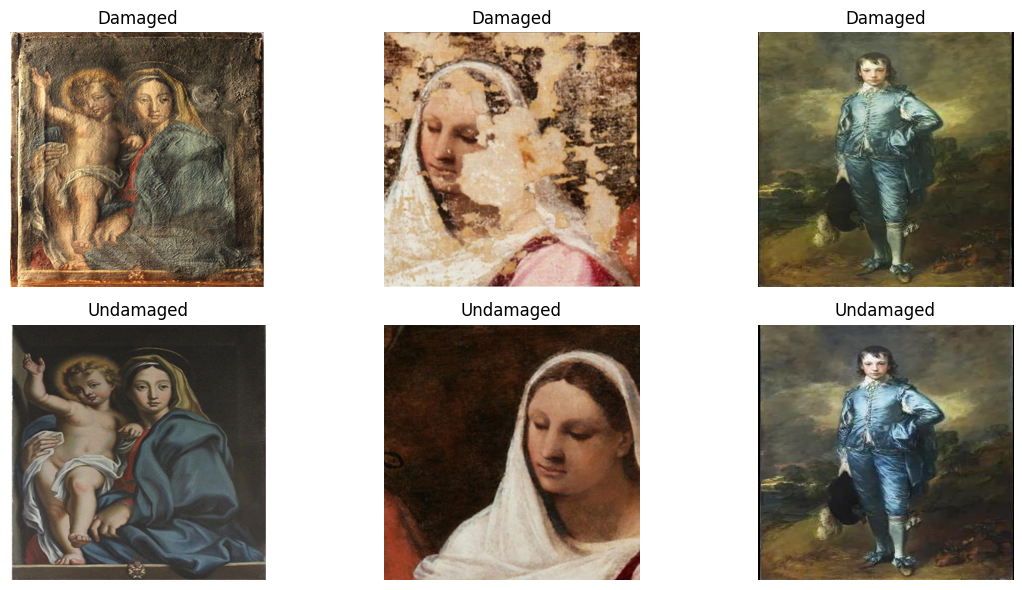

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
img_size = (256, 256)

for i in range(3):
    key = common_keys[i]

    damaged_img = Image.open(os.path.join(damaged_path, damaged_map[key])).convert("RGB").resize(img_size)
    undamaged_img = Image.open(os.path.join(undamaged_path, undamaged_map[key])).convert("RGB").resize(img_size)

    axes[0, i].imshow(damaged_img)
    axes[0, i].set_title("Damaged")
    axes[0, i].axis('off')

    axes[1, i].imshow(undamaged_img)
    axes[1, i].set_title("Undamaged")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

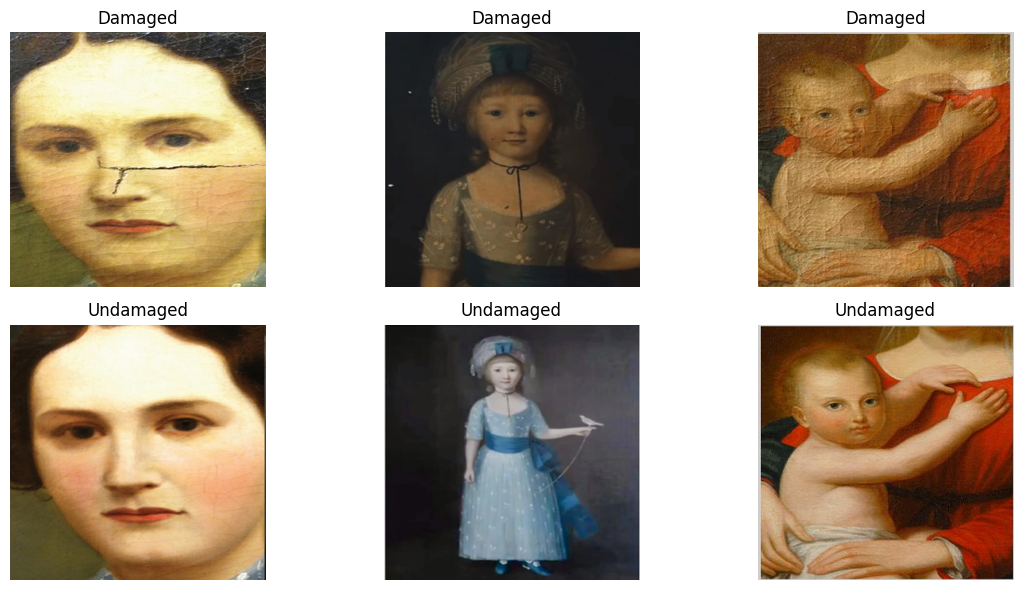

In [ ]:
import random

# Pick 3 random keys
random_keys = random.sample(common_keys, 3)

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
img_size = (256, 256)

for i, key in enumerate(random_keys):
    damaged_img = Image.open(os.path.join(damaged_path, damaged_map[key])).convert("RGB").resize(img_size)
    undamaged_img = Image.open(os.path.join(undamaged_path, undamaged_map[key])).convert("RGB").resize(img_size)

    axes[0, i].imshow(damaged_img)
    axes[0, i].set_title("Damaged")
    axes[0, i].axis('off')

    axes[1, i].imshow(undamaged_img)
    axes[1, i].set_title("Undamaged")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# ---------- Image dimensions ----------
img_size = (256, 256)

# ---------- Prepare arrays ----------
X = []  # Damaged images (input)
Y = []  # Undamaged images (target)

print(f"Processing {len(common_keys)} matched image pairs...")

for key in tqdm(common_keys):
    try:
        damaged_img = Image.open(os.path.join(damaged_path, damaged_map[key])).convert("RGB").resize(img_size)
        undamaged_img = Image.open(os.path.join(undamaged_path, undamaged_map[key])).convert("RGB").resize(img_size)

        X.append(np.array(damaged_img) / 255.0)   # Normalize to [0,1]
        Y.append(np.array(undamaged_img) / 255.0)
    except Exception as e:
        print(f"⚠️ Error processing {key}: {e}")

# Convert lists to NumPy arrays
X = np.array(X)
Y = np.array(Y)

# ---------- Output shapes ----------
print("✅ Input (damaged) shape:", X.shape)
print("✅ Target (undamaged) shape:", Y.shape)

Processing 111 matched image pairs...


100%|██████████| 111/111 [00:05<00:00, 18.50it/s]


✅ Input (damaged) shape: (111, 256, 256, 3)
✅ Target (undamaged) shape: (111, 256, 256, 3)


In [ ]:
# ---------- Model Definition ----------
def build_restoration_model(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)  # 128x128

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)  # 64x64

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2))(x)  # 32x32

    # Decoder
    x = UpSampling2D((2, 2))(encoded)  # 64x64
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D((2, 2))(x)  # 128x128
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D((2, 2))(x)  # 256x256
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(inputs, decoded)
    return model

In [ ]:
# ---------- Compile ----------
model = build_restoration_model()
model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 256, 256, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 741,379 (2.83 MB)

 Trainable params: 741,379 (2.83 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ---------- Split the data ----------
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

print("Train shape:", X_train.shape, Y_train.shape)
print("Val shape:", X_val.shape, Y_val.shape)

Train shape: (99, 256, 256, 3) (99, 256, 256, 3)
Val shape: (12, 256, 256, 3) (12, 256, 256, 3)


In [ ]:
# ---------- Callbacks ----------
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# ---------- Train ----------
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=30,
    batch_size=8,
    callbacks=[early_stop]
)

Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 99s 7s/step - loss: 0.0761 - mae: 0.2413 - val_loss: 0.0542 - val_mae: 0.1963
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 139s 7s/step - loss: 0.0673 - mae: 0.2218 - val_loss: 0.0540 - val_mae: 0.1950
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 142s 7s/step - loss: 0.0670 - mae: 0.2247 - val_loss: 0.0537 - val_mae: 0.1940
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 143s 7s/step - loss: 0.0673 - mae: 0.2222 - val_loss: 0.0504 - val_mae: 0.1869
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 97s 7s/step - loss: 0.0601 - mae: 0.2078 - val_loss: 0.0475 - val_mae: 0.1769
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 92s 7s/step - loss: 0.0508 - mae: 0.1881 - val_loss: 0.0451 - val_mae: 0.1666
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 145s 7s/step - loss: 0.0463 - mae: 0.1783 - val_loss: 0.0403 - val_mae: 0.1541
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 143s 7s/step - loss: 0.0413 - mae: 0.1606 - val_loss: 0.0367 - val_mae: 0.1495
Epoch 9/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 141s 7s/step - loss: 0.0403 -

In [ ]:
# Save full model (architecture + weights + optimizer)
model.save('/content/drive/MyDrive/basic_img_restoration_model1.h5')

In [ ]:
'''
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError

# Load model with custom_objects
model = load_model(
    '/content/drive/MyDrive/basic_img_restoration_model.h5',
    compile=True,
    custom_objects={
        "mse": MeanSquaredError,  # register mse explicitly
        "mae": tf.keras.metrics.MeanAbsoluteError
    }
)
'''

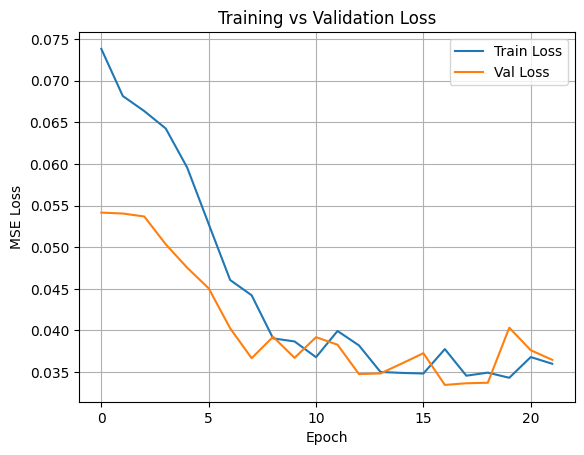

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# ---------- Pick a random sample ----------
idx = random.randint(0, X_val.shape[0] - 1)

damaged = X_val[idx]
true_restored = Y_val[idx]

# Predict the restoration
predicted_restored = model.predict(np.expand_dims(damaged, axis=0))[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


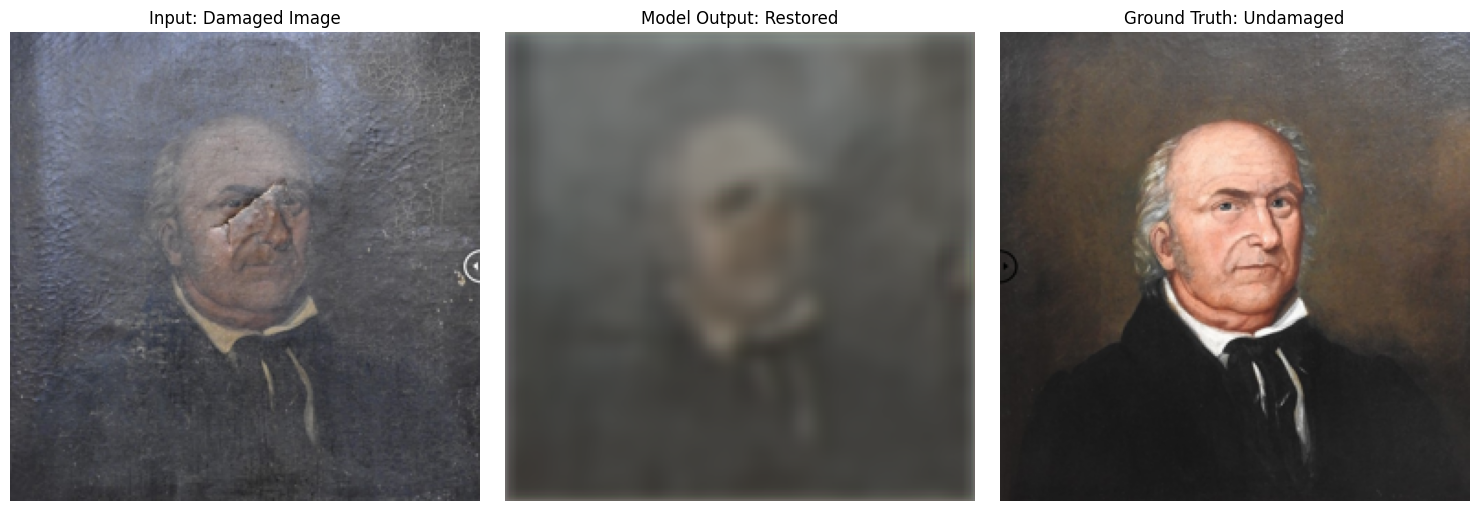

In [ ]:
# ---------- Plot ----------
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(damaged)
axes[0].set_title("Input: Damaged Image")
axes[0].axis('off')

axes[1].imshow(predicted_restored)
axes[1].set_title("Model Output: Restored")
axes[1].axis('off')

axes[2].imshow(true_restored)
axes[2].set_title("Ground Truth: Undamaged")
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# ---------- Pick a random sample ----------
idx2 = random.randint(0, X_val.shape[0] - 1)

damaged = X_val[idx2]
true_restored = Y_val[idx2]

# Predict the restoration
predicted_restored = model.predict(np.expand_dims(damaged, axis=0))[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


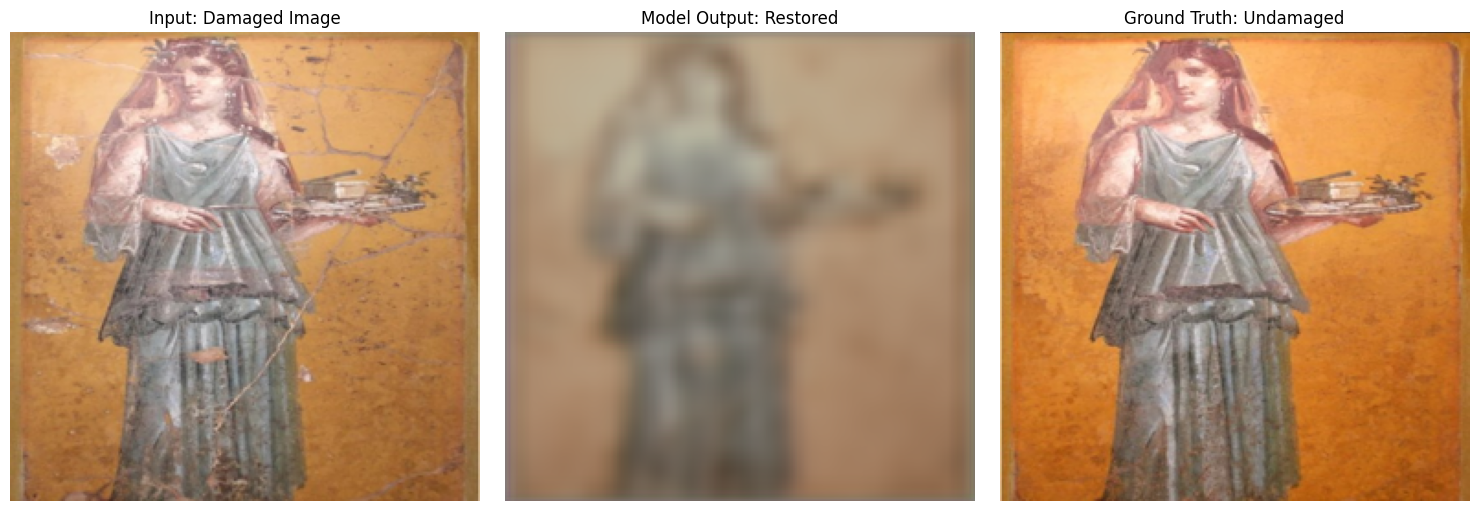

In [ ]:
# ---------- Plot ----------
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(damaged)
axes[0].set_title("Input: Damaged Image")
axes[0].axis('off')

axes[1].imshow(predicted_restored)
axes[1].set_title("Model Output: Restored")
axes[1].axis('off')

axes[2].imshow(true_restored)
axes[2].set_title("Ground Truth: Undamaged")
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# ---------- Pick a random sample ----------
idx3 = random.randint(0, X_val.shape[0] - 1)

damaged = X_val[idx3]
true_restored = Y_val[idx3]

# Predict the restoration
predicted_restored = model.predict(np.expand_dims(damaged, axis=0))[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


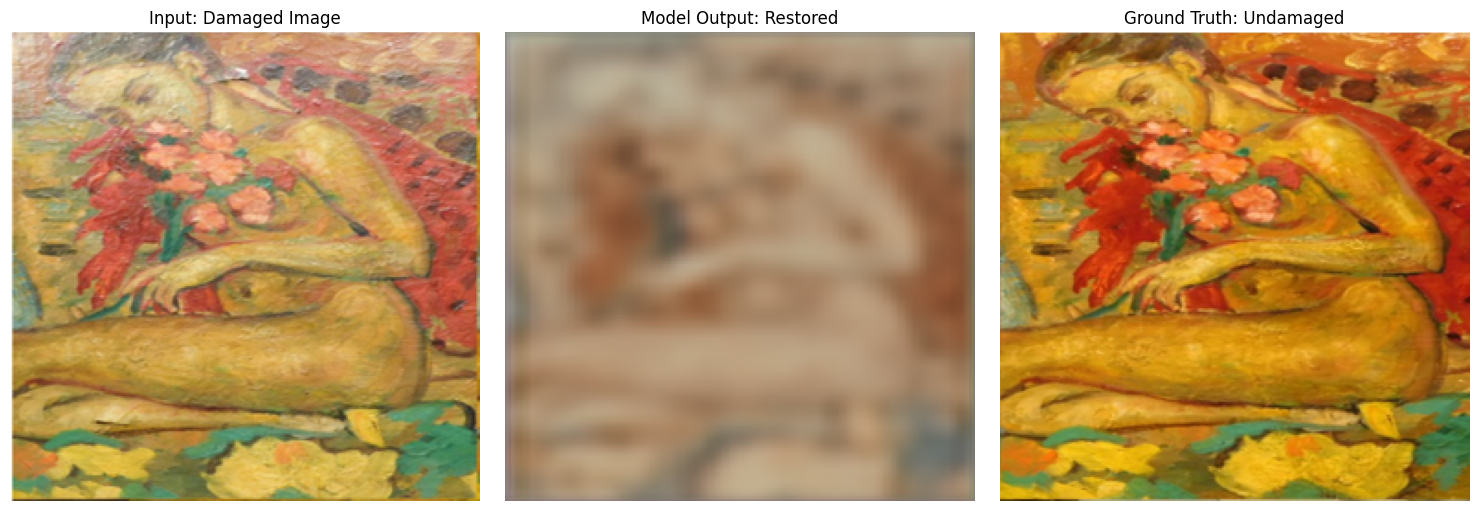

In [ ]:
# ---------- Plot ----------
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(damaged)
axes[0].set_title("Input: Damaged Image")
axes[0].axis('off')

axes[1].imshow(predicted_restored)
axes[1].set_title("Model Output: Restored")
axes[1].axis('off')

axes[2].imshow(true_restored)
axes[2].set_title("Ground Truth: Undamaged")
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# ---------- Pick a random sample ----------
idx4 = random.randint(0, X_val.shape[0] - 1)

damaged = X_val[idx4]
true_restored = Y_val[idx4]

# Predict the restoration
predicted_restored = model.predict(np.expand_dims(damaged, axis=0))[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


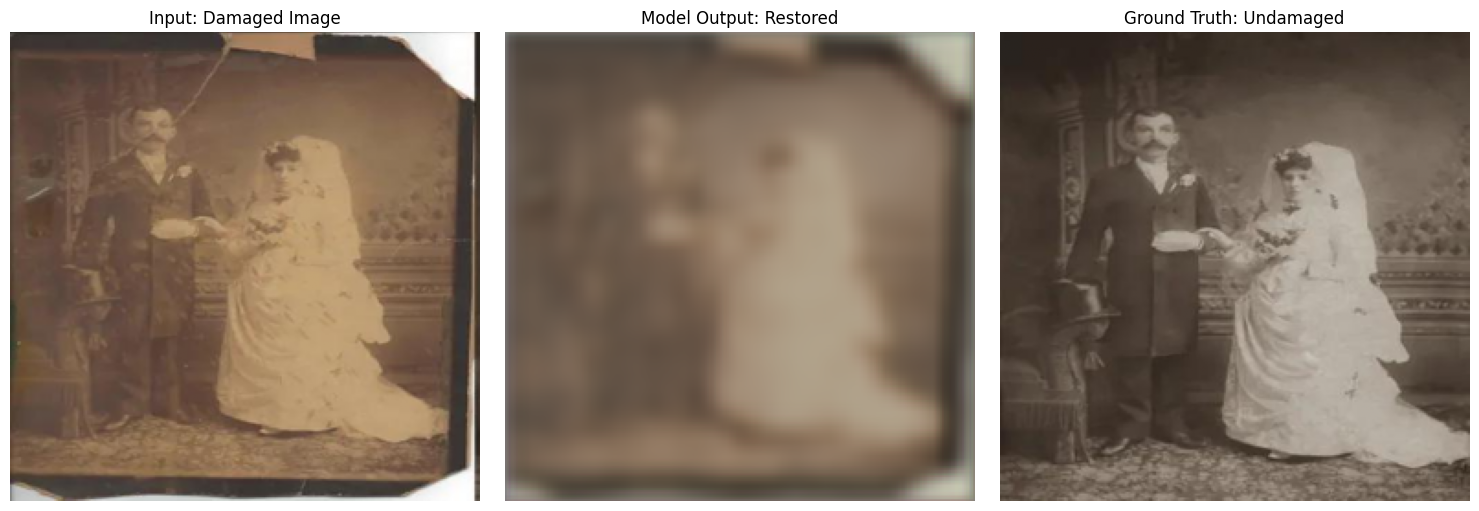

In [ ]:
# ---------- Plot ----------
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(damaged)
axes[0].set_title("Input: Damaged Image")
axes[0].axis('off')

axes[1].imshow(predicted_restored)
axes[1].set_title("Model Output: Restored")
axes[1].axis('off')

axes[2].imshow(true_restored)
axes[2].set_title("Ground Truth: Undamaged")
axes[2].axis('off')

plt.tight_layout()
plt.show()

#Ver2 - predicts only the noise instead of whole restored image

In [ ]:
# -------------------------
# Imports
# -------------------------
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# -------------------------
# Residual Block (with projection for channel mismatch)
# -------------------------
def residual_block(x, filters, kernel_size=3):
    shortcut = x
    # Project shortcut if channels mismatch
    if x.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, padding="same")(shortcut)

    x = layers.Conv2D(filters, kernel_size, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, kernel_size, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

# -------------------------
# Adaptive Instance Normalization
# -------------------------
class AdaIN(layers.Layer):
    def __init__(self, channels, style_dim, epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.channels = channels
        self.style_dim = style_dim
        self.epsilon = epsilon
        self.gamma_dense = layers.Dense(channels)
        self.beta_dense = layers.Dense(channels)

    def call(self, inputs):
        content, style = inputs
        mean_c = tf.reduce_mean(content, axis=[1,2], keepdims=True)
        std_c = tf.math.sqrt(tf.reduce_mean((content - mean_c)**2, axis=[1,2], keepdims=True) + self.epsilon)
        normalized = (content - mean_c) / std_c

        gamma = tf.reshape(self.gamma_dense(style), [-1,1,1,self.channels])
        beta  = tf.reshape(self.beta_dense(style), [-1,1,1,self.channels])
        return normalized * (1.0 + gamma) + beta

# -------------------------
# Build Denoising Model
# -------------------------
def build_denoise_model(input_shape=(256,256,3), base_filters=64, style_dim=128):
    inp = Input(shape=input_shape, name="damaged_input")

    # Encoder
    x = layers.Conv2D(base_filters, 3, padding="same", activation="relu")(inp)
    skip1 = x
    x = layers.MaxPool2D()(x)  # 128x128

    x = layers.Conv2D(base_filters*2, 3, padding="same", activation="relu")(x)
    skip2 = x
    x = layers.MaxPool2D()(x)  # 64x64

    x = layers.Conv2D(base_filters*4, 3, padding="same", activation="relu")(x)
    skip3 = x
    x = layers.MaxPool2D()(x)  # 32x32

    x = layers.Conv2D(base_filters*8, 3, padding="same", activation="relu")(x)
    x = residual_block(x, base_filters*8)  # bottleneck

    # Style vector
    style_vec = layers.GlobalAveragePooling2D()(x)
    style_vec = layers.Dense(style_dim, activation="relu")(style_vec)
    style_vec = layers.Dense(style_dim, activation="relu")(style_vec)

    # Decoder
    x = layers.UpSampling2D()(x)  # 64x64
    x = layers.Conv2D(base_filters*4, 3, padding="same", activation="relu")(x)
    x = AdaIN(base_filters*4, style_dim)([x, style_vec])
    x = layers.Concatenate()([x, skip3])
    x = residual_block(x, base_filters*4)

    x = layers.UpSampling2D()(x)  # 128x128
    x = layers.Conv2D(base_filters*2, 3, padding="same", activation="relu")(x)
    x = AdaIN(base_filters*2, style_dim)([x, style_vec])
    x = layers.Concatenate()([x, skip2])
    x = residual_block(x, base_filters*2)

    x = layers.UpSampling2D()(x)  # 256x256
    x = layers.Conv2D(base_filters, 3, padding="same", activation="relu")(x)
    x = AdaIN(base_filters, style_dim)([x, style_vec])
    x = layers.Concatenate()([x, skip1])
    x = residual_block(x, base_filters)

    # Predict noise/residual
    pred_noise = layers.Conv2D(3, 3, padding="same", activation="tanh", name="predicted_noise")(x)

    # Restored image = clamp(damaged - predicted_noise, 0,1)
    restored = layers.Lambda(lambda args: tf.clip_by_value(args[0]-args[1],0.0,1.0),
                             name="restored_image")([inp, pred_noise])

    model = Model(inputs=inp, outputs=[pred_noise, restored], name="Denoise_AE_Residual")
    return model

# -------------------------
# Compile
# -------------------------
model = build_denoise_model(input_shape=(256,256,3))
model.compile(optimizer=Adam(1e-4),
              loss={"predicted_noise":"mae", "restored_image":"mae"},
              loss_weights={"predicted_noise":0.5, "restored_image":1.0},
              metrics={"restored_image":["mae", "mse"]})

model.summary()


In [ ]:
restored = model.predict(np.expand_dims(damaged,0))[1]  # restored_image output
